# Deep Dive Tutorial: Data Modeling

## Learning Objectives

In this tutorial you will learn how to:
1. Create a catalog
2. Register tables
3. Analyse and set feature job settings
4. Define data cleaning operations
5. Define entities and table relationships
6. Create views of tables
7. Join views

## Set up the prerequisites

Learning Objectives

In this section you will:
* import libraries
* connect to the remote featurebyte server

### Load the featurebyte library and connect to the remote featurebyte server

In [ ]:
import urllib.request

# install featurebyte package and download supporting library
!pip install featurebyte
urllib.request.urlretrieve("https://raw.githubusercontent.com/featurebyte/featurebyte-hosted-tutorials/main/tutorials/notebooks/prebuilt_catalogs.py", "prebuilt_catalogs.py")

In [1]:
# library imports
import pandas as pd
import numpy as np
from datetime import datetime

# load the featurebyte SDK
import featurebyte as fb

# replace <api_token> with your API token you receieved after registering
fb.register_tutorial_api_token("api_token")

# define the database name for this tutorial
TUTORIAL_DATABASE = "TUTORIAL_DATASETS"

12:14:21 | INFO     | Using configuration file at: /Users/smillet/.featurebyte/config.yaml
12:14:21 | WARNING  | No valid profile specified. Update config file or specify valid profile name with "use_profile".
12:14:21 | INFO     | Using profile: tutorial
12:14:21 | INFO     | Using configuration file at: /Users/smillet/.featurebyte/config.yaml
12:14:21 | INFO     | Active profile: tutorial (https://tutorials.featurebyte.com/api/v1)
12:14:21 | WARNING  | Remote SDK version (0.3.0.dev117) is different from local (0.3.0.dev133). Update local SDK to avoid unexpected behavior.
12:14:21 | INFO     | No catalog activated.
12:14:21 | INFO     | 0 feature list, 0 feature deployed


## Create a catalog

Learning Objectives

In this section you will:
* learn about catalogs
* activate a new catalog

### Concept: Catalog

A Catalog object operates as a centralized metadata repository for organizing tables, entities, features, and feature lists and other objects to facilitate feature serving for a specific domain.
By employing a catalog, your team members can share, search, access, and reuse these assets.

### Example: Create a new catalog

In [2]:
catalog_name = "deep dive data modeling " + datetime.now().strftime("%Y%m%d:%H%M")
print(catalog_name)

# create a catalog
catalog = fb.Catalog.create(catalog_name, feature_store_name="playground")

deep dive data modeling 20230719:1214


## Register tables

Learning Objectives

In this section you will:
* be introduced to the case study dataset
* learn the about FeatureByte catalog table types
* declare FeatureByte catalog tables

### Case Study: French grocery dataset

The French grocery dataset contains four tables containing data from a chain of grocery stores.

The data source has already been declared in the playground feature store that was installed as part of FeatureByte.

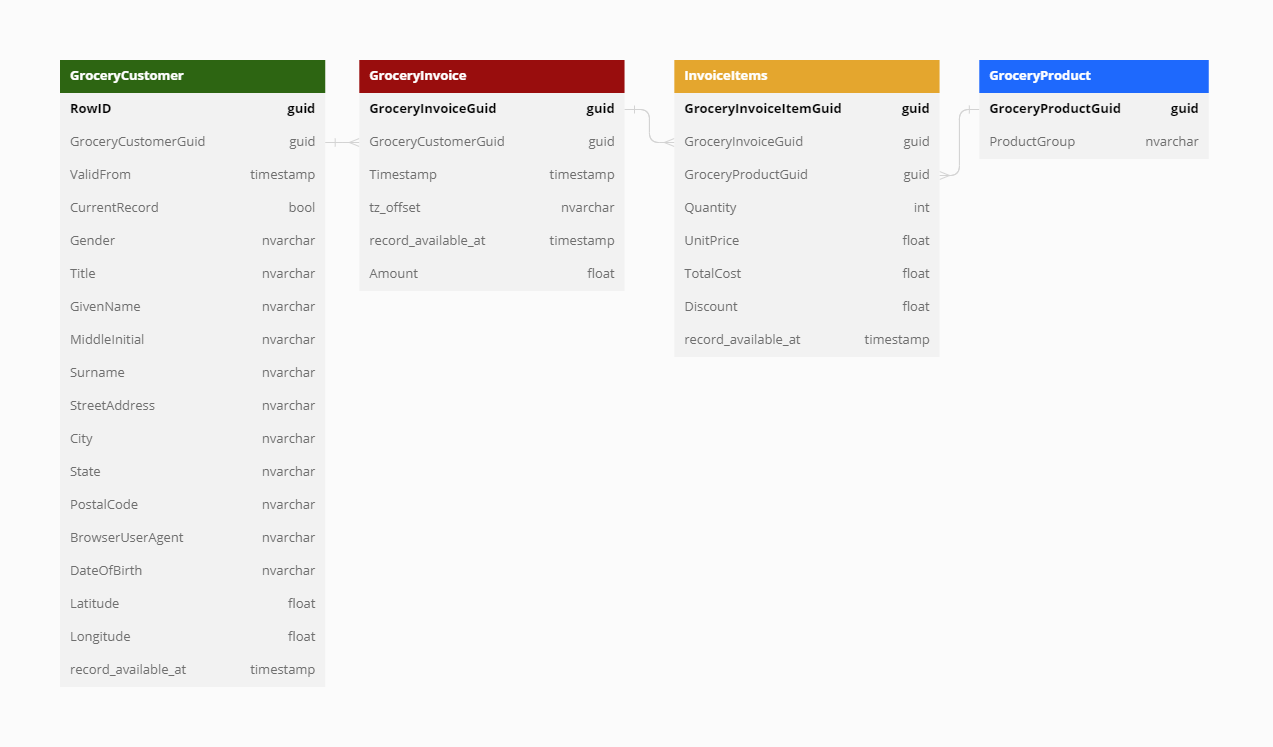

### Concept: Data source

A data source represents a collection of source tables that the feature store can access.

### Example: Connect to a pre-defined data source

In [3]:
# get data source from the local spark feature store
ds = fb.FeatureStore.get("playground").get_data_source()

# list the databases in the data source
ds.list_databases()

['SNOWFLAKE', 'SNOWFLAKE_SAMPLE_DATA', 'TUTORIAL', 'TUTORIAL_DATASETS']

In [4]:
# list all schemas in the spark catalog
ds.list_schemas(TUTORIAL_DATABASE)

['CREDITCARD', 'GROCERY', 'HEALTHCARE', 'INFORMATION_SCHEMA']

In [6]:
# list the tables in the grocery schema
ds.list_source_tables(TUTORIAL_DATABASE, "GROCERY")

['GROCERYPRODUCT', 'GROCERYCUSTOMER', 'GROCERYINVOICE', 'INVOICEITEMS']

### Concept: Source table

A source table is a table from a data warehouse that the feature store can access.

### Concept: Catalog table

A Catalog Table provides a centralized location for metadata about a source table. This metadata determines the type of operations that can be applied to the table's views and includes essential information for feature engineering.


### Concept: Table types

Understanding the type of data contained in a table is crucial because it helps determine the appropriate feature engineering techniques that can be applied to the table.

Featurebyte supports four of the most common types of data table.

1. Slowly Changing Dimension (SCD) table
2. Event table
3. Item table
4. Dimension table

### Concept: Slowly changing dimension (SCD) table

An SCD Table represents a table in a data warehouse that contains data that changes slowly and unpredictably over time.

There are two main types of SCDs:
- Type 1: Overwrites old data with new data
- Type 2: Maintains a history of changes by creating a new record for each change.

FeatureByte only supports the use of Type 2 SCDs since SCDs of Type 1 may cause data leaks during model training and poor performance during inference.

An SCD Table of Type 2 utilizes a natural key to distinguish each active row and facilitate tracking of changes over time. The SCD table employs effective and expiration date columns to determine the active status of a row. In certain instances, an active flag column may replace the expiration date column to indicate if a row is currently active.

To create an SCD Table in FeatureByte, it is necessary to identify columns for the natural key, effective timestamp, optionally surrogate key, expiration timestamp, and active flag.

### Example: Declare a slowly changing dimension table

In [7]:
# declare the grocery customer table
customer_table = ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYCUSTOMER"
).create_scd_table(
    name="GROCERYCUSTOMER",
    surrogate_key_column="RowID",
    natural_key_column="GroceryCustomerGuid",
    effective_timestamp_column="ValidFrom",
    current_flag_column="CurrentRecord",
    record_creation_timestamp_column="record_available_at",
)

# show the column names and types for grocery customer
ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYCUSTOMER"
).dtypes

12:16:28 | ERROR    | RBAC: User is not allowed to perform READ on Scd Table


RecordRetrievalException: RBAC: User is not allowed to perform READ on Scd Table

In [8]:
# show sample data
customer_table.sample(5)

RowID                   GroceryCustomerGuid  \
0  e46287d9-3c3e-4565-a32a-6d0740b63a04  a8cd7041-3f41-4a6b-9745-798e2300a717   
1  15057786-e3b4-4f13-8521-d1d84285e716  bbaff8e5-44ab-4f61-a4e6-405f274bf429   
2  5ec5d068-02f4-49fe-853a-038347dc505a  9359ef7b-7fd8-4587-bc40-e89f6acc1218   
3  8ca33786-cb20-49ab-8fac-2ab76a7912c0  7ce7bcc5-9ded-4f9a-bd9a-5f85f8ea6cca   
4  fcf52fbc-6459-4bc7-a72f-fca1d49243cc  fb39edea-9527-4a9b-a4f5-f9cf697a124f   

            ValidFrom  Gender Title   GivenName MiddleInitial  Surname  \
0 2019-01-10 09:06:37  female   Ms.        Anne             C     Lang   
1 2022-07-03 16:01:40    male   Mr.       Henry             R  Saindon   
2 2019-01-09 20:44:25  female  Mrs.   Madeleine             X   Gagnon   
3 2020-10-16 11:39:05  female   Ms.  Christiane             A   Devost   
4 2019-01-01 13:53:50    male   Mr.     Faustin             E   Gauvin   

                   StreetAddress       City                       State  \
0                   6 Rue Roussy    ORLÉANS                      Centre   
1           59 rue Clement Marot     PESSAC                   Aquitaine   
2    71 rue du Faubourg National    TAVERNY               Île-de-France   
3               40 rue Nationale      PARIS               Île-de-France   
4  57 boulevard de la Liberation  MARSEILLE  Provence-Alpes-Côte d'Azur   

  PostalCode                                   BrowserUserAgent DateOfBirth  \
0      45000  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  1974-04-27   
1      33600  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2001-03-26   
2      95150  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...  1964-11-25   
3      75007  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...  2003-11-05   
4      13014  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5...  1987-05-04   

    Latitude  Longitude record_available_at  CurrentRecord  
0  47.983993   1.981258 2019-01-10 10:01:00           True  
1  44.769466  -0.613324 2022-07-03 17:01:00          False  
2  49.121484   2.260801 2019-01-09 21:01:00           True  
3  48.923195   2.251334 2020-10-16 12:01:00           True  
4  43.326089   5.311465 2019-01-01 14:01:00           True

### Concept: Event table

An Event table  represents a table in the data warehouse where each row indicates a unique business event occurring at a particular time.

Event tables can take various forms, such as an Order table in E-commerce, Credit Card Transactions in Banking, Doctor Visits in Healthcare, and Clickstream on the Internet.

To create an Event Table in FeatureByte, it is necessary to identify two important columns in your data: the event key and timestamp. The event key is a unique identifier for each event, while the timestamp indicates when the event occurred.

If your data warehouse is a Snowflake data warehouse, FeatureByte accepts timestamp columns that include time zone offset information.

For timestamp columns without time zone offset information or for non-Snowflake data warehouses, you can specify a separate column that provides the time zone offset information. By doing so, date parts transforms in the event timestamp column will be based on the local time instead of UTC.

Additionally, the column that represents the record creation timestamp may be identified to enable an automatic analysis of data availability and freshness of the source table. This analysis can assist in selecting the default scheduling of the computation of features associated with the Event table.

### Example: Declare an event table

In [9]:
# register GroceryInvoice as an event data
invoice_table = ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYINVOICE"
).create_event_table(
    name="GROCERYINVOICE",
    event_id_column="GroceryInvoiceGuid",
    event_timestamp_column="Timestamp",
    event_timestamp_timezone_offset_column="tz_offset",
    record_creation_timestamp_column="record_available_at",
)

# show the column names and types for grocery invoice
ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYINVOICE"
).dtypes

GroceryInvoiceGuid       VARCHAR
GroceryCustomerGuid      VARCHAR
Timestamp              TIMESTAMP
tz_offset                VARCHAR
record_available_at    TIMESTAMP
Amount                     FLOAT
dtype: object

In [10]:
invoice_table.preview()

GroceryInvoiceGuid                   GroceryCustomerGuid  \
0  73396167-19bc-4bd4-8064-ebbda4909101  5c96089d-95f7-4a12-ab13-e082836253f1   
1  684492c1-31bd-4d70-8018-0296073532b7  5c96089d-95f7-4a12-ab13-e082836253f1   
2  2ce65601-a030-4007-8afa-df3c8b815014  5c96089d-95f7-4a12-ab13-e082836253f1   
3  77e9a7f1-78d9-43a5-9135-06eb4577c123  5c96089d-95f7-4a12-ab13-e082836253f1   
4  a865b722-3efc-48c8-aa7b-e59b897b5553  5c96089d-95f7-4a12-ab13-e082836253f1   
5  1eed961f-1730-494b-9845-b767cc907d97  5c96089d-95f7-4a12-ab13-e082836253f1   
6  f3d88431-7826-4112-ad85-a1a6c4259aef  5c96089d-95f7-4a12-ab13-e082836253f1   
7  52412379-f9d6-4512-a29f-4a2f2880ff99  5c96089d-95f7-4a12-ab13-e082836253f1   
8  99e069d2-71bf-49c0-8d58-4facfb178c9d  5c96089d-95f7-4a12-ab13-e082836253f1   
9  770b26fc-48c3-48a9-8631-626f640e080a  5c96089d-95f7-4a12-ab13-e082836253f1   

            Timestamp tz_offset record_available_at  Amount  
0 2022-01-12 19:24:51    +01:00 2022-01-12 20:01:00   15.34  
1 2022-01-18 16:04:37    +01:00 2022-01-18 17:01:00   14.99  
2 2022-01-21 13:36:07    +01:00 2022-01-21 14:01:00   18.68  
3 2022-02-01 20:59:24    +01:00 2022-02-01 21:01:00   66.09  
4 2022-02-10 17:53:31    +01:00 2022-02-10 18:01:00   42.25  
5 2022-02-12 18:10:54    +01:00 2022-02-12 19:01:00   35.81  
6 2022-02-24 16:52:58    +01:00 2022-02-24 17:01:00   74.00  
7 2022-03-01 10:23:14    +01:00 2022-03-01 11:01:00   34.58  
8 2022-03-06 19:22:16    +01:00 2022-03-06 20:01:00   85.74  
9 2022-03-13 15:22:09    +01:00 2022-03-13 16:01:00   49.31

In [11]:
# show sample data
invoice_table.sample(5)

GroceryInvoiceGuid                   GroceryCustomerGuid  \
0  6f0f8768-59b0-4bf1-aa21-258c83515e45  d2fc87d2-3584-4c8f-9359-b3ff10b5dc09   
1  7d12246f-d5f7-4ed6-8aa2-8611beb7f613  b6d4377e-9f04-4c04-bc56-b970e54279ca   
2  49887643-3fa1-4171-89e0-344160238c01  c22fa3eb-55a5-4a4f-9301-38f6b6f0567e   
3  2cfae7b0-b3a2-4973-9561-de8e4788e388  e034e01c-50de-42f0-a879-82c093af5f49   
4  360eb328-b0cb-4f75-bf64-d6b5216b50ad  7a1bc5dc-e198-419e-b972-0abbdf8903c1   

            Timestamp tz_offset record_available_at  Amount  
0 2022-12-26 16:29:21    +01:00 2022-12-26 17:01:00   24.04  
1 2023-02-18 16:00:03    +01:00 2023-02-18 17:01:00   25.61  
2 2022-06-23 18:24:52    +02:00 2022-06-23 19:01:00   23.88  
3 2022-12-19 15:49:29    +01:00 2022-12-19 16:01:00    6.21  
4 2022-02-13 16:52:33    +01:00 2022-02-13 17:01:00   14.30

### Concept: Item table

An Item table represents a table in the data warehouse containing detailed information about a specific business event.

For instance, an Item table may contain information about:
- Product Items purchased in Customer Orders
- or Drug Prescriptions issued during Doctor Visits by Patients.

Typically, an Item table has a 'one-to-many' relationship with an Event table. Despite not explicitly including a timestamp, it is inherently linked to an event timestamp through its association with the Event table.

To create an Item Table, it is necessary to identify the columns that represent the item key and the event key and determine which Event table is associated with the Item table.

### Example: Declare an item table

In [12]:
# register invoice items as an item table
items_table = ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="INVOICEITEMS"
).create_item_table(
    name="INVOICEITEMS",
    event_id_column="GroceryInvoiceGuid",
    item_id_column="GroceryInvoiceItemGuid",
    event_table_name="GROCERYINVOICE",
)

# show the column names and types for invoice items
ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="INVOICEITEMS"
).dtypes

GroceryInvoiceItemGuid      VARCHAR
GroceryInvoiceGuid          VARCHAR
GroceryProductGuid          VARCHAR
Quantity                      FLOAT
UnitPrice                     FLOAT
TotalCost                     FLOAT
Discount                      FLOAT
record_available_at       TIMESTAMP
dtype: object

In [13]:
# show sample data
items_table.sample(5)

GroceryInvoiceItemGuid                    GroceryInvoiceGuid  \
0  0c5181e3-9d9c-402d-902a-1649c3a26232  8d99deb7-78cc-4924-ac04-9cb99e1e282c   
1  5b853ed2-aea7-4fad-aaa5-bcadbef0eba8  163e7004-db43-4e0d-a093-cd7bf27caf10   
2  d2d7633e-3bdf-430d-920e-13825cad3e19  4aac4b3b-0cd9-4bf7-a650-68f40fb85865   
3  7c4c38cc-7150-4bca-b2c1-0d4616d4809f  5226254f-97d6-4080-a4fa-0269f2da1bc0   
4  cd0d8e88-e8fd-41d9-a4a4-8c9d4e05a1d8  af5633bc-0008-40ee-b1a1-8dfd4c98eba9   

                     GroceryProductGuid  Quantity  UnitPrice  TotalCost  \
0  8b9739d4-1a3f-4c96-886d-d0492ba45c07       1.0       1.74       1.74   
1  a7fd9147-874f-4f3d-b262-3e408cc30db8       1.0       2.50       2.50   
2  5d9e7f80-4c03-44b9-b44b-5083f0645261       1.0       0.75       0.75   
3  a59f0ed9-f70d-474d-9347-4605af059856       3.0       0.66       1.98   
4  5f38510e-1c5f-481a-98e8-8c282b03e7bf       1.0       1.29       1.29   

   Discount record_available_at  
0      0.18 2022-08-02 10:01:00  
1      0.39 2023-04-14 17:01:00  
2      0.00 2022-06-28 13:01:00  
3      0.00 2022-02-24 13:01:00  
4      0.00 2022-03-20 14:01:00

### Concept: Dimension table

A Dimension table represents a table in the data warehouse containing static descriptive data.

Using a Dimension table requires special attention. If the data in the table changes slowly, it is not advisable to use it because these changes can cause significant data leaks during model training and adversely affect the inference performance. In such cases, it is recommended to use a Slowly Changing Dimension table of Type 2 that maintains a history of changes.

To create a Dimension Table in FeatureByte, it is necessary to identify which column represents its primary key.

In [14]:
# register GroceryProduct as a dimension table
product_table = ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYPRODUCT"
).create_dimension_table(name="GROCERYPRODUCT", dimension_id_column="GroceryProductGuid")

# show the column names and types for grocery product
ds.get_source_table(
    database_name=TUTORIAL_DATABASE, schema_name="GROCERY", table_name="GROCERYPRODUCT"
).dtypes

GroceryProductGuid    VARCHAR
ProductGroup          VARCHAR
dtype: object

In [15]:
# show sample data
product_table.sample(5)

GroceryProductGuid               ProductGroup
0  8a9c2ad6-865d-45b6-a039-6d0ebcc69b74                     Épices
1  22a5f17e-feea-45e7-9cc0-49a9eb8029ac                       Chat
2  89de4090-3a29-4418-ae9b-34b93a484dc4                      Pains
3  454dfbe9-75f2-4a58-a225-179b0533ea9a                  Vinaigres
4  6e936197-17c3-4b8b-8427-8536704f9d2d  Frites et Pommes de terre

## Analyse and set feature job settings

Learning Objectives

In this section you will:
* learn about feature jobs
* analyze data to estimate optimal feature job settings
* declare feature job settings

### Background

FeatureByte is designed to work with data warehouses that receive regular data refreshes from operational sources, which means that feature values may differ in terms of freshness and availability. If these operational limitations are not taken into account, inconsistencies between offline and online feature values may occur.

To prevent such inconsistencies, it's crucial to synchronize the frequency of batch feature computations with the frequency of source table refreshes, and to compute features after the source table refresh is fully completed. In addition, for historical serving to accurately replicate the production environment, it's essential to use data that was available at the historical points-in-time, considering the present or future latency of data. Latency of data refers to the time difference between the timestamp of an event and the timestamp at which the event data is accessible for ingestion. Any period during which data may be missing is referred to as a "blind spot".

To address these challenges, the Feature Job Setting in FeatureByte captures information about the frequency of batch feature computations, the timing of the batch process, and the assumed blind spot for the data. This helps ensure consistency between offline and online feature values, and accurate historical serving that reflects the conditions present in the production environment.

### Concept: Feature job

A Feature Job is a batch process that generates both offline and online tiles and feature values for a specific feature before storing them in the feature store. The scheduling of a Feature Job is determined by the feature job settings associated with the respective feature.

Feature job orchestration is initiated when a feature is deployed and continues until the feature deployment is disabled, ensuring the feature store consistently possesses the latest values for each feature.

### Concept: Feature job setting

The Feature Job Setting in FeatureByte captures essential details about batch feature computations for the online feature store, including the frequency and timing of the batch process, as well as the assumed blind spot for the data. This helps to maintain consistency between offline and online feature values and ensures accurate historical serving that reflects the production environment. The setting comprises three parameters:
1. The frequency parameter specifies how often the batch process should run.
2. The time_modulo_frequency parameter defines the timing from the end of the frequency time period to when the feature job commences. For example, a feature job with the following settings (frequency 60m, time_modulo_frequency: 130s) will start 2 min and 10 seconds after the beginning of each hour: 00:02:10, 01:02:10, 02:02:10, …,  15:02:10, …, 23:02:10.
3. The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

Case study: A data warehouse refreshes each hour. The data refresh starts 10 seconds after the hour and is usually finished within 2 minutes. Sometimes the data refresh misses the latest data, up to a maximum of the last 30 seconds at the end of the hour. Therefore the feature job settings will be:
* frequency: 60m
* time_modulo_frequency: 10s + 2m + 5s (a safety buffer) = 135s
* blind_spot: 30s + 10s + 2m + 5s = 165s

To accommodate changes in source data management, Feature Job Setting supports versioning of both features and feature lists. The scheduling information and blind spot are stored in the Feature Job Setting metadata associated with each feature.

While Feature Jobs are primarily designed to support online requests, this information is also used during historical requests to minimize offline-online inconsistency.

### Concept: Feature job setting recommendations

FeatureByte automatically analyzes data availability and freshness of an event table in order to suggest an optimal setting for scheduling Feature Jobs and associated Blind Spot information.

This analysis relies on the presence of record creation timestamps in the source table, typically added when updating data in the warehouse. The analysis focuses on a recent time window, such as the past four weeks.

FeatureByte estimates the data update frequency based on the distribution of time intervals among the sequence of record creation timestamps. It also assesses the timeliness of source table updates and identifies late jobs using an outlier detection algorithm. By default, the recommended scheduling time takes late jobs into account.

To accommodate data that may not arrive on time during warehouse updates, a blind spot is proposed for determining the cutoff for feature aggregation windows, in addition to scheduling frequency and time of the Feature Job. The suggested blind spot offers a percentage of late data closest to the user-defined tolerance, with a default of 0.005%.

To validate the Feature Job schedule and blind spot recommendations, a backtest is conducted. Users can also backtest their own settings.

### Example: Feature job settings analysis

In [16]:
# initialize the feature job settings for the invoice table
invoice_table.initialize_default_feature_job_setting()

Done! |████████████████████████████████████████| 100% in 12.1s (0.08%/s)        


### Concept: Default Feature Job Setting

The Default Feature Job Setting establishes the default setting used by features that aggregate data in a table, ensuring consistency of the Feature Job Setting across features created by different team members. While it's possible to override the setting during feature declaration, using the Default Feature Job Setting simplifies the process of setting up the Feature Job Setting for each feature.

### Example: View a default feature job setting

In [17]:
# display the default feature job setting for the invoice table
invoice_table.default_feature_job_setting

FeatureJobSetting(blind_spot='120s', frequency='3600s', time_modulo_frequency='65s')

### Example: Manually override a default feature job setting

* The frequency parameter specifies how often the batch process should run.
* The time_modulo_frequency parameter defines the timing of the batch process.
* The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

In [18]:
# set a more conservative feature job setting for the invoice table
manual_setting = fb.FeatureJobSetting(
    blind_spot="135s",
    frequency="60m",
    time_modulo_frequency="90s",
)
invoice_table.update_default_feature_job_setting(manual_setting)

## Define data cleaning operations

Learning Objectives

In this section you will:
* learn the different types of cleaning operations supported by FeatureByte
* declare cleaning operations

### Concept: Cleaning operations

Cleaning Operations determine the procedure for cleaning data in a table column before performing feature engineering. The cleaning operations can either be set as a default operation in the metadata of a table column or established when creating a view in a manual mode.

These operations specify how to manage the following scenarios:
* Missing values
* Disguised values
* Values that are not in an anticipated list
* Numeric values and dates that are out of boundaries
* String values when numeric values are expected

For a specific column, define an ordered sequence of cleaning operations. Ensure that values imputed in earlier steps are not marked for cleaning in later operations.

### Example: Correct negative discounts and missing discount amounts

In [19]:
# discount amount cannot be negative
items_table.Discount.update_critical_data_info(
    cleaning_operations=[
        fb.MissingValueImputation(imputed_value=0),
        fb.ValueBeyondEndpointImputation(type="less_than", end_point=0, imputed_value=0),
    ]
)

### Example: Remove infinite prices

In [20]:
# fix infinite unit price by removing these values
items_table.UnitPrice.update_critical_data_info(
    cleaning_operations=[
        fb.ValueBeyondEndpointImputation(type="greater_than", end_point=100000, imputed_value=None),
    ]
)

## Define entities and table relationships

Learning Objectives

In this section you will:
* learn the purpose of entities
* declare entities
* tag table columns with their associated entities

### Concept: Entity

An Entity object contains metadata on a real-world object or concept represented or referenced by tables within your data warehouse.

Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases.

All features must relate to an entity (or entities) as their primary unit of analysis.

### Concept: Entity serving name

An entity's serving name is the name of the unique identifier that is used to identify the entity during a preview or serving request. Typically, the serving name for an entity is the name of the primary key (or natural key) of the table that represents the entity. An entity can have multiple serving names for convenience, but the unique identifier should remain unique.

### Example: Declare new entities

In [21]:
entity1 = catalog.create_entity(name="grocerycustomer", serving_names=["GROCERYCUSTOMERGUID"])
entity2 = catalog.create_entity(name="groceryinvoice", serving_names=["GROCERYINVOICEGUID"])
entity3 = catalog.create_entity(name="groceryproduct", serving_names=["GROCERYPRODUCTGUID"])
entity4 = catalog.create_entity(name="frenchstate", serving_names=["FRENCHSTATE"])

### Concept: Entity Tagging

The Entity Tagging process involves identifying the specific columns in tables that identify or reference a particular entity. These columns are often primary keys, natural keys, or foreign keys. This process is a critical step in preparing data before feature engineering as all features must relate to an entity (or entities) as their primary unit of analysis.

### Example: Entity tagging

In [22]:
# tag the entities for the grocery customer table
customer_table.GroceryCustomerGuid.as_entity("grocerycustomer")
customer_table.State.as_entity("frenchstate")

# tag the entities for the grocery invoice table
invoice_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
invoice_table.GroceryCustomerGuid.as_entity("grocerycustomer")

# tag the entities for the grocery items table
items_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
items_table.GroceryProductGuid.as_entity("groceryproduct")

# tag the entities for the grocery items table
product_table.GroceryProductGuid.as_entity("groceryproduct")

### Concept: Parent-Child Relationship

A Parent-Child Relationship is a hierarchical connection that links one entity (the child) to another (the parent). Each child entity key value can have only one parent entity key value, but a parent entity key value can have multiple child entity key values.

Examples of parent-child relationships include:

* Hierarchical organization chart: A company's employees are arranged in a hierarchy, with each employee having a manager. The employee entity represents the child, and the manager entity represents the parent.
* Product catalog: In an e-commerce system, a product catalog may be categorized into subcategories and categories. Each category or subcategory represents a child of its parent category.
* Geographical hierarchy: In a geographical data model, cities are arranged in states, which are arranged in countries. Each city is the child of its parent state, and each state is the child of its parent country.
* Credit Card hierarchy: A credit card transaction is the child of a card and a merchant. A card is a child of a customer. A customer is a child of a customer city. And a merchant is a child of a merchant city.

In FeatureByte, the parent-child relationship is automatically established when the primary key (or natural key in the context of a SCD table) identifies one entity. This entity is the child entity. Other entities that are referenced in the table are identified as parent entities.

These relationships can be used to suggest, facilitate and verify joins during feature engineering and streamline the process of serving feature lists containing multiple entity-assigned features.

### Example: Display entity relationships

In [23]:
# list the entity relationships
catalog.list_relationships()

id relationship_type           entity  \
0  645c47ae9c28d6ed179a15b1      child_parent   groceryinvoice   
1  645c47ae9c28d6ed179a15aa      child_parent  grocerycustomer   

    related_entity   relation_table relation_table_type  enabled  \
0  grocerycustomer   GROCERYINVOICE         event_table     True   
1      frenchstate  GROCERYCUSTOMER           scd_table     True   

               created_at updated_at  
0 2023-05-11 01:41:02.733       None  
1 2023-05-11 01:41:02.436       None

## Create views of tables

Learning Objectives

In this section you will:
* learn the purpose of views
* create views from tables
* transform data in a view
* filter rows in a view

### Concept: FeatureByte Views

A view is a local virtual table that can be modified and joined to other views to prepare data before feature definition. A view does not contain any data of its own.

Views in FeatureByte allow operations similar to Pandas, such as:

- creating and transforming columns and extracting lags
- filtering records, capturing attribute changes, and joining views

Unlike Pandas DataFrames, which require loading all data into memory, views are materialized only when needed during previews or feature materialization.

When a view is created, it inherits the metadata of the catalog table it originated from. Currently, five types of views are supported:

- Event Views created from an Event table
- Item Views created from an Item table
- Dimension Views created from a Dimension table
- Slowly Changing Dimension (SCD) Views created from a SCD table
- Change Views created from a SCD table.

Two view construction modes are available:
* Auto (default): Automatically cleans data according to default operations specified for each column within the table and excludes special columns not meant for feature engineering.
* Manual: Allows custom cleaning operations without applying default cleaning operations.

Although views provide access to cleaned data, you can still perform data manipulation using the raw data from the source table. To do this, utilize the view's raw attribute, which enables you to work directly with the unprocessed data of the source table.


### Example: Create views from tables

In [24]:
# get the view objects
product_view = product_table.get_view()
items_view = items_table.get_view()
invoice_view = invoice_table.get_view()
customer_view = customer_table.get_view()

In [25]:
# display the customer view
customer_view.sample(5)

RowID                   GroceryCustomerGuid  \
0  e46287d9-3c3e-4565-a32a-6d0740b63a04  a8cd7041-3f41-4a6b-9745-798e2300a717   
1  15057786-e3b4-4f13-8521-d1d84285e716  bbaff8e5-44ab-4f61-a4e6-405f274bf429   
2  5ec5d068-02f4-49fe-853a-038347dc505a  9359ef7b-7fd8-4587-bc40-e89f6acc1218   
3  8ca33786-cb20-49ab-8fac-2ab76a7912c0  7ce7bcc5-9ded-4f9a-bd9a-5f85f8ea6cca   
4  fcf52fbc-6459-4bc7-a72f-fca1d49243cc  fb39edea-9527-4a9b-a4f5-f9cf697a124f   

            ValidFrom  Gender Title   GivenName MiddleInitial  Surname  \
0 2019-01-10 09:06:37  female   Ms.        Anne             C     Lang   
1 2022-07-03 16:01:40    male   Mr.       Henry             R  Saindon   
2 2019-01-09 20:44:25  female  Mrs.   Madeleine             X   Gagnon   
3 2020-10-16 11:39:05  female   Ms.  Christiane             A   Devost   
4 2019-01-01 13:53:50    male   Mr.     Faustin             E   Gauvin   

                   StreetAddress       City                       State  \
0                   6 Rue Roussy    ORLÉANS                      Centre   
1           59 rue Clement Marot     PESSAC                   Aquitaine   
2    71 rue du Faubourg National    TAVERNY               Île-de-France   
3               40 rue Nationale      PARIS               Île-de-France   
4  57 boulevard de la Liberation  MARSEILLE  Provence-Alpes-Côte d'Azur   

  PostalCode                                   BrowserUserAgent DateOfBirth  \
0      45000  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  1974-04-27   
1      33600  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2001-03-26   
2      95150  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...  1964-11-25   
3      75007  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...  2003-11-05   
4      13014  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5...  1987-05-04   

    Latitude  Longitude  
0  47.983993   1.981258  
1  44.769466  -0.613324  
2  49.121484   2.260801  
3  48.923195   2.251334  
4  43.326089   5.311465

### Example: Transform data in a view

In [26]:
# extract the operating system from the BrowserUserAgent column
customer_view["OperatingSystemIsWindows"] = customer_view.BrowserUserAgent.str.contains("Windows")

# display a sample of the results
display(
    customer_view[["GroceryCustomerGuid", "BrowserUserAgent", "OperatingSystemIsWindows"]].sample()
)

GroceryCustomerGuid           ValidFrom  \
0  a8cd7041-3f41-4a6b-9745-798e2300a717 2019-01-10 09:06:37   
1  bbaff8e5-44ab-4f61-a4e6-405f274bf429 2022-07-03 16:01:40   
2  9359ef7b-7fd8-4587-bc40-e89f6acc1218 2019-01-09 20:44:25   
3  7ce7bcc5-9ded-4f9a-bd9a-5f85f8ea6cca 2020-10-16 11:39:05   
4  fb39edea-9527-4a9b-a4f5-f9cf697a124f 2019-01-01 13:53:50   
5  f15331f3-52ad-4f2a-acc2-bd71900823a7 2019-01-01 13:50:34   
6  9e88c6d9-7c42-4a00-96b0-0012d79a1e15 2019-01-05 17:46:28   
7  dd1dcef9-26b3-4de6-95b0-36410c1ecf98 2022-05-10 10:16:54   
8  c87f9847-fa5a-4dd8-a62a-40565c8996d0 2019-01-15 13:19:54   
9  db726554-ea0d-422d-b4de-39efa949f60c 2019-01-03 17:00:37   

                                    BrowserUserAgent  OperatingSystemIsWindows  
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                      True  
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                      True  
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...                     False  
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...                      True  
4  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5...                     False  
5  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                      True  
6  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...                      True  
7  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                      True  
8  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...                     False  
9  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...                      True

### Example: Filtering a view

The syntax for filtering a view is the same as pandas.

In [27]:
# create a filter for filtering rows to see only small purchases
filter = invoice_view["Amount"] < 2
filtered_invoice_view = invoice_view[filter]

display(filtered_invoice_view.sample())

GroceryInvoiceGuid                   GroceryCustomerGuid  \
0  161f6a8a-ec8c-47dc-84ab-a71fbd8a5f62  18c313c7-9613-4a77-b282-f6f821deeca4   
1  11172038-9e19-4a57-8b29-d852aa421a75  38d069c8-794b-4c5a-aaf6-3323f1244752   
2  e2b70b26-8640-46b6-b8e1-e361d472a178  3019bdbf-667c-4081-acb5-26cd2d559c5e   
3  19d899b5-47fa-4426-b980-bf1f4cbd39a1  b21ae11c-83cf-4146-832e-1163413a3295   
4  116615bb-0685-4614-a349-bfb74d35f314  9e88c6d9-7c42-4a00-96b0-0012d79a1e15   
5  8e2a218a-3b8b-4a23-a8a8-3ac319646e4d  38d069c8-794b-4c5a-aaf6-3323f1244752   
6  fadb3a86-0926-4bb8-b3a6-fb0e944cb670  d0f6e138-1bc3-4097-839d-fe0ca74bb14c   
7  a060d5d5-16bf-4c35-89e2-da875593bbd2  38d069c8-794b-4c5a-aaf6-3323f1244752   
8  9c75e090-1306-4896-bd01-5b9a22ef3f62  9c23c4e8-f0e8-4aa4-83e9-3d3525461a8f   
9  3734b200-ef0e-4075-99f1-1c3a53be44e6  3cc23dcd-7238-4a92-bb01-61126d9ff825   

            Timestamp tz_offset  Amount  
0 2022-04-28 13:20:12    +02:00    1.65  
1 2022-09-06 22:14:19    +02:00    1.00  
2 2022-11-14 00:59:55    +03:00    0.69  
3 2023-03-05 13:09:25    +01:00    1.08  
4 2022-07-06 06:01:45    +02:00    1.79  
5 2022-02-24 21:56:48    +01:00    0.67  
6 2022-09-09 14:32:51    +02:00    1.78  
7 2023-01-08 20:54:38    +01:00    1.29  
8 2022-05-23 14:58:45    +02:00    0.59  
9 2023-01-09 15:55:35    +01:00    1.69

### Example: Access raw data

In [28]:
# copy the raw discount amount, before cleaning, into the view
items_view["RawDiscount"] = items_view.raw["Discount"]
items_view["RawUnitPrice"] = items_view.raw["UnitPrice"]

# display examples where the data was cleaned
display(items_view.sample())

GroceryInvoiceItemGuid                    GroceryInvoiceGuid  \
0  0c5181e3-9d9c-402d-902a-1649c3a26232  8d99deb7-78cc-4924-ac04-9cb99e1e282c   
1  5b853ed2-aea7-4fad-aaa5-bcadbef0eba8  163e7004-db43-4e0d-a093-cd7bf27caf10   
2  d2d7633e-3bdf-430d-920e-13825cad3e19  4aac4b3b-0cd9-4bf7-a650-68f40fb85865   
3  7c4c38cc-7150-4bca-b2c1-0d4616d4809f  5226254f-97d6-4080-a4fa-0269f2da1bc0   
4  cd0d8e88-e8fd-41d9-a4a4-8c9d4e05a1d8  af5633bc-0008-40ee-b1a1-8dfd4c98eba9   
5  d010fe4e-266c-4c7a-93dc-e9382bf701e3  c252db99-7e47-4b0b-9bb9-e5dc3806b61a   
6  8e662549-45a1-44d6-9303-ed57ec075ee5  19d29c98-4a14-44b8-9674-70b1d13b8a56   
7  aee67dc0-b9cc-494c-983c-615bc7e6d407  03e29874-d7fc-49ab-8fd6-7e5e96c50020   
8  c44ca187-bfec-4d36-942d-12b53d21e6c9  80c69dc8-a9f9-40a3-952a-4f48949d05fc   
9  200d5fcc-cb83-4d25-a4d8-823dd6b85532  02233998-c4d0-466d-ac86-1e4e24236fc0   

                     GroceryProductGuid  Quantity  UnitPrice  TotalCost  \
0  8b9739d4-1a3f-4c96-886d-d0492ba45c07       1.0       1.74       1.74   
1  a7fd9147-874f-4f3d-b262-3e408cc30db8       1.0       2.50       2.50   
2  5d9e7f80-4c03-44b9-b44b-5083f0645261       1.0       0.75       0.75   
3  a59f0ed9-f70d-474d-9347-4605af059856       3.0       0.66       1.98   
4  5f38510e-1c5f-481a-98e8-8c282b03e7bf       1.0       1.29       1.29   
5  e5a3021a-c595-48b6-98b5-57eaf3b5ef30       1.0       1.00       1.00   
6  cefc9497-91d9-4cc0-ab7e-89c30f76d77b       1.0       8.99       8.99   
7  cb48f980-116b-491d-acdf-f09adcbaa182       1.0       2.50       2.50   
8  8813b20d-4c0f-44aa-afc6-9c13e3f9524a       1.0       1.19       1.19   
9  926c9abd-9153-46b4-9a07-0d440224ad2b       1.0       0.25       0.25   

   Discount record_available_at           Timestamp  \
0      0.18 2022-08-02 10:01:00 2022-08-02 09:27:44   
1      0.39 2023-04-14 17:01:00 2023-04-14 16:32:57   
2      0.00 2022-06-28 13:01:00 2022-06-28 12:14:50   
3      0.00 2022-02-24 13:01:00 2022-02-24 12:19:15   
4      0.00 2022-03-20 14:01:00 2022-03-20 13:53:14   
5      0.05 2022-05-01 19:01:00 2022-05-01 18:47:30   
6      0.00 2022-12-30 18:01:00 2022-12-30 17:50:47   
7      2.09 2022-06-05 14:01:00 2022-06-05 13:07:49   
8      0.10 2022-01-16 22:01:00 2022-01-16 21:01:03   
9      0.00 2022-04-20 16:01:00 2022-04-20 15:51:18   

                    GroceryCustomerGuid tz_offset  RawDiscount  RawUnitPrice  
0  c6ef9073-3351-4f54-869a-4c926a479520    +02:00         0.18          1.74  
1  09fbee0c-521e-40ee-a2ff-8ed4187dcbc4    +02:00         0.39          2.50  
2  53cfd09f-9293-4d66-b876-0087e3a5f35b    +02:00         0.00          0.75  
3  86a8a582-9cb8-4850-9de8-8e064f2111f2    +01:00         0.00          0.66  
4  9c23c4e8-f0e8-4aa4-83e9-3d3525461a8f    +01:00         0.00          1.29  
5  3cc23dcd-7238-4a92-bb01-61126d9ff825    +02:00         0.05          1.00  
6  12c2d702-1b92-4375-8fd4-5b3bd18f7d87    +01:00         0.00          8.99  
7  2328730d-9979-45de-8511-117697556fbc    +02:00         2.09          2.50  
8  b21ae11c-83cf-4146-832e-1163413a3295    +01:00         0.10          1.19  
9  db2d5721-8869-40f7-984c-a94d614fdf69    +02:00         0.00          0.25

## Join views

Learning Objectives

In this section you will learn:
* how views are joined
* the purpose of natural keys
* which view types can be joined
* how joins are frequently unnecessary

### Concept: Principles of featurebyte joins

In featurebyte:
* Joins operate on views
* Join criteria by common entities, and by event timestamps for joins of event views and slowly changing data
* Similarly to pandas, for the right-hand-side view, the join key must be its index (its natural key).
* Joins add columns to an existing view
* Joins never increase the number of rows in a view.
* By default, the number of rows do not change after a join. However, the number of rows may reduce if an inner join is selected.
* Only one-to-one and many-to-one relationships are supported. One-to-many and many-to-many relationships are not supported.
* Always start with the view that has the <b>many</b> side of the relationship, then join the view that has the <b>one</b> side of the relationship
* Similarly to a left join, rows with no match will contain missing values for the joined fields

### Concept: Natural key

A Natural Key is a generally accepted identifier used to identify real-world objects uniquely. In a Slowly Changing Dimension (SCD) table, a natural key (also called alternate key) is a column or a group of columns that remain constant over time and uniquely identifies each active row in the table at any point-in-time.

This key is crucial in maintaining and analyzing the historical changes made in the table.

### Concept: View joins

To join two views, use the `join()` method of the left view and specify the right view object in the `other_view` parameter. The method will match rows from both views based on a shared key, which is either the primary key of the right view or the natural key if the right view is an SCD view.

If the shared key identifies an entity that is referenced in the left view or the column name of the shared key is the same in both views, the `join()` method will automatically identify the column in the left view to use for the join.

By default, a left join is performed, and the resulting view will have the same number of rows as the left view. However, you can set the `how` parameter to 'inner' to perform an inner join. In this case, the resulting view will only contain rows where there is a match between the columns in both tables.

When the right view is an SCD view, the event timestamp of the left view determines which record of the right view to join.

### Example: Join event data to item data

Event data is automatically joined to item data via the event ID.

When an ItemView is created, the event timestamp and columns representing entities in the related event table are automatically added.

The preferred method to add columns from the event view is the join_event_data_attributes method.

In [29]:
# copy the invoice amount into the items view
items_view = items_view.join_event_table_attributes(["Amount"], event_suffix="_invoice_total")

display(items_view.preview())

GroceryInvoiceItemGuid                    GroceryInvoiceGuid  \
0  c6c7c746-782c-418b-b123-7ded5a8d8d30  e87223dc-c5ef-4360-8637-86dc69af5d39   
1  a2c85c99-65a6-480b-9259-3339a3b5dc19  e87223dc-c5ef-4360-8637-86dc69af5d39   
2  c8d0bba1-5adf-4747-b6f7-cd16925392dc  e87223dc-c5ef-4360-8637-86dc69af5d39   
3  adb793ab-90ff-4bc0-a9eb-47f71952d97c  e87223dc-c5ef-4360-8637-86dc69af5d39   
4  700d6299-9e33-4a10-8054-7cdcb9fa8529  e87223dc-c5ef-4360-8637-86dc69af5d39   
5  fe0683c7-f8ae-4aa3-a1a8-6e762c262644  e87223dc-c5ef-4360-8637-86dc69af5d39   
6  1b194981-b1bb-4306-a760-8131493f544f  e87223dc-c5ef-4360-8637-86dc69af5d39   
7  c5f9cd59-4f4a-4a39-9d7a-7b7f0c2bb07f  e87223dc-c5ef-4360-8637-86dc69af5d39   
8  a6ac8ea1-fb10-4d11-9470-8b83d14e2f45  e87223dc-c5ef-4360-8637-86dc69af5d39   
9  c35b60b8-941f-4fa6-b272-41c7bfca228c  e87223dc-c5ef-4360-8637-86dc69af5d39   

                     GroceryProductGuid  Quantity  UnitPrice  TotalCost  \
0  2d19bd87-a6ea-4553-9caa-1ab6d7e322b9       1.0      2.000       2.00   
1  ed2445ad-8a97-4a4d-9f5c-eb253d66f916       1.0      0.990       0.99   
2  77b6847c-65bd-4e40-925f-7c2e2db80936       1.0      1.990       1.99   
3  7b3f3630-f2e4-4d18-8174-36d35d171069       1.0      2.000       2.00   
4  8a01f8db-9796-4e17-8e8d-b893770e5a40       1.0      1.000       1.00   
5  525dfef6-62a2-488d-9f2e-c4631cc4a8a2       1.0      1.290       1.29   
6  c18c8a1c-bf87-4b2c-bc2b-8ea468e92d82       2.0      1.145       2.29   
7  9ee0d42e-dcb7-493b-98ed-ff63d951431d       1.0      1.290       1.29   
8  a99853f4-a90e-4b8b-97d0-d42aad75d1f0       1.0      1.290       1.29   
9  49686449-3e3d-445f-b98b-26e86027855a       1.0      1.590       1.59   

   Discount record_available_at                   GroceryCustomerGuid  \
0      1.49 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
1      0.20 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
2      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
3      1.15 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
4      0.61 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
5      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
6      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
7      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
8      0.50 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
9      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   

            Timestamp tz_offset  RawDiscount  RawUnitPrice  \
0 2022-01-01 17:39:59    +01:00         1.49         2.000   
1 2022-01-01 17:39:59    +01:00         0.20         0.990   
2 2022-01-01 17:39:59    +01:00         0.00         1.990   
3 2022-01-01 17:39:59    +01:00         1.15         2.000   
4 2022-01-01 17:39:59    +01:00         0.61         1.000   
5 2022-01-01 17:39:59    +01:00         0.00         1.290   
6 2022-01-01 17:39:59    +01:00         0.00         1.145   
7 2022-01-01 17:39:59    +01:00         0.00         1.290   
8 2022-01-01 17:39:59    +01:00         0.50         1.290   
9 2022-01-01 17:39:59    +01:00         0.00         1.590   

   Amount_invoice_total  
0                 66.84  
1                 66.84  
2                 66.84  
3                 66.84  
4                 66.84  
5                 66.84  
6                 66.84  
7                 66.84  
8                 66.84  
9                 66.84

### Example: Join slowly changing data to event data

When the right view of a join is an SCD view, the event timestamp of the left view determines which record of the right view to join.

In [30]:
# Join selected columns from the grocery customer view with the grocery invoice view
invoice_view = invoice_view.join(customer_view[["Gender", "State"]], rsuffix="_Customer")

display(invoice_view.sample())

GroceryInvoiceGuid                   GroceryCustomerGuid  \
0  5ad2590a-0738-465c-be7a-7249fc387544  2caad2c2-39ed-4117-9dcd-794f6ff4f6e6   
1  79139a81-6570-4358-a335-61fbec00c8cc  5c96089d-95f7-4a12-ab13-e082836253f1   
2  7d69b2c5-f415-4c10-8f2d-fe0b56c6f54e  d0251d4c-f16a-4db2-a4d2-f025cb90b3be   
3  ebbfa5fe-2e4d-490c-8360-a048e064ba78  144a0fe4-2137-43f6-b266-411b9eb7cb31   
4  2a1148ea-ac27-4087-aea2-137821f24c74  9c23c4e8-f0e8-4aa4-83e9-3d3525461a8f   
5  3cb42b92-6ba5-41a6-88ea-f9b5b0b7b5e5  d0251d4c-f16a-4db2-a4d2-f025cb90b3be   
6  67fd5315-27b9-41f8-912c-836ab2ea2b45  41c1bdf5-b596-4fc4-9570-ecd86a0d9a98   
7  0c96481d-dcc3-4e12-930b-1c34973737b3  6da5a03a-ed30-4a6d-bcd9-ecb8b12dceea   
8  902a2c2a-638b-46ca-903b-de497c72ee27  a276ad57-8d19-40a7-a779-d1be67c0b41c   
9  7335ea1f-d47d-4e1e-952e-cc717cb97da2  e490ab6d-c699-44c3-a284-41a7bbb1ee6f   

            Timestamp tz_offset  Amount Gender_Customer      State_Customer  
0 2023-01-30 13:14:04    +01:00    4.46          female  Nord-Pas-de-Calais  
1 2022-12-22 20:07:57    +01:00   82.97            male  Nord-Pas-de-Calais  
2 2022-09-16 10:20:04    +02:00    5.49            male       Midi-Pyrénées  
3 2022-02-22 19:04:30    +01:00   38.10          female       Île-de-France  
4 2022-03-25 10:25:45    +01:00    3.32          female       Île-de-France  
5 2022-11-10 16:38:16    +01:00   22.45            male       Midi-Pyrénées  
6 2022-02-04 13:05:23    +01:00    5.89          female    Pays de la Loire  
7 2022-02-18 23:14:19    +01:00   47.58            male  Nord-Pas-de-Calais  
8 2022-01-02 12:01:39    +01:00    1.00          female         Rhône-Alpes  
9 2022-05-12 00:04:11    +02:00    1.91          female       Île-de-France

### Example: Join dimension data to item data

In [31]:
# join the grocery product view with the grocery items view
items_view = items_view.join(product_view)

display(items_view.preview())

GroceryInvoiceItemGuid                    GroceryInvoiceGuid  \
0  c6c7c746-782c-418b-b123-7ded5a8d8d30  e87223dc-c5ef-4360-8637-86dc69af5d39   
1  a2c85c99-65a6-480b-9259-3339a3b5dc19  e87223dc-c5ef-4360-8637-86dc69af5d39   
2  c8d0bba1-5adf-4747-b6f7-cd16925392dc  e87223dc-c5ef-4360-8637-86dc69af5d39   
3  adb793ab-90ff-4bc0-a9eb-47f71952d97c  e87223dc-c5ef-4360-8637-86dc69af5d39   
4  700d6299-9e33-4a10-8054-7cdcb9fa8529  e87223dc-c5ef-4360-8637-86dc69af5d39   
5  fe0683c7-f8ae-4aa3-a1a8-6e762c262644  e87223dc-c5ef-4360-8637-86dc69af5d39   
6  1b194981-b1bb-4306-a760-8131493f544f  e87223dc-c5ef-4360-8637-86dc69af5d39   
7  c5f9cd59-4f4a-4a39-9d7a-7b7f0c2bb07f  e87223dc-c5ef-4360-8637-86dc69af5d39   
8  a6ac8ea1-fb10-4d11-9470-8b83d14e2f45  e87223dc-c5ef-4360-8637-86dc69af5d39   
9  c35b60b8-941f-4fa6-b272-41c7bfca228c  e87223dc-c5ef-4360-8637-86dc69af5d39   

                     GroceryProductGuid  Quantity  UnitPrice  TotalCost  \
0  2d19bd87-a6ea-4553-9caa-1ab6d7e322b9       1.0      2.000       2.00   
1  ed2445ad-8a97-4a4d-9f5c-eb253d66f916       1.0      0.990       0.99   
2  77b6847c-65bd-4e40-925f-7c2e2db80936       1.0      1.990       1.99   
3  7b3f3630-f2e4-4d18-8174-36d35d171069       1.0      2.000       2.00   
4  8a01f8db-9796-4e17-8e8d-b893770e5a40       1.0      1.000       1.00   
5  525dfef6-62a2-488d-9f2e-c4631cc4a8a2       1.0      1.290       1.29   
6  c18c8a1c-bf87-4b2c-bc2b-8ea468e92d82       2.0      1.145       2.29   
7  9ee0d42e-dcb7-493b-98ed-ff63d951431d       1.0      1.290       1.29   
8  a99853f4-a90e-4b8b-97d0-d42aad75d1f0       1.0      1.290       1.29   
9  49686449-3e3d-445f-b98b-26e86027855a       1.0      1.590       1.59   

   Discount record_available_at                   GroceryCustomerGuid  \
0      1.49 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
1      0.20 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
2      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
3      1.15 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
4      0.61 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
5      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
6      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
7      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
8      0.50 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   
9      0.00 2022-01-01 18:01:00  caef12d6-ea0d-42ee-894a-77933ebf7f71   

            Timestamp tz_offset  RawDiscount  RawUnitPrice  \
0 2022-01-01 17:39:59    +01:00         1.49         2.000   
1 2022-01-01 17:39:59    +01:00         0.20         0.990   
2 2022-01-01 17:39:59    +01:00         0.00         1.990   
3 2022-01-01 17:39:59    +01:00         1.15         2.000   
4 2022-01-01 17:39:59    +01:00         0.61         1.000   
5 2022-01-01 17:39:59    +01:00         0.00         1.290   
6 2022-01-01 17:39:59    +01:00         0.00         1.145   
7 2022-01-01 17:39:59    +01:00         0.00         1.290   
8 2022-01-01 17:39:59    +01:00         0.50         1.290   
9 2022-01-01 17:39:59    +01:00         0.00         1.590   

   Amount_invoice_total                     ProductGroup  
0                 66.84          Plats Cuisinés Surgelés  
1                 66.84  Pâtes, Riz, Purées et Féculents  
2                 66.84                           Épices  
3                 66.84                   Premiers Soins  
4                 66.84                        Jus Frais  
5                 66.84                          Bonbons  
6                 66.84               Chips et Tortillas  
7                 66.84                          Bonbons  
8                 66.84                            Pains  
9                 66.84                        Jus Frais

### Example: Use an inner join

Inner joins are useful for filtering views because they drop unmatched rows.

In [32]:
# get a grocery items view
soda_items_view = items_view.copy()

# create a filter to only include products that have the text "Soda" in the product group
filter = product_view.ProductGroup.str.contains("Soda")

# apply the filter to the grocery product view
soda_product_view = product_view[filter]

# join the grocery product view with the grocery items view
soda_items_view = soda_items_view.join(soda_product_view, how="inner", rsuffix="_Soda")

# preview the result
display(soda_items_view.preview())

GroceryInvoiceItemGuid                    GroceryInvoiceGuid  \
0  13876e34-1fa7-4099-9c1e-1acdb0f8cd6e  a7c15443-ec3a-412b-9b9b-2045d025f21c   
1  e510e8bc-7770-4ee1-848c-d933c0bcab91  a7c15443-ec3a-412b-9b9b-2045d025f21c   
2  04e9a957-cfb0-4b5b-8787-c85862d1c4ec  ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123   
3  7566d89e-b619-493e-b2b3-6a37353336a4  ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123   
4  e1b6f89c-75c9-452e-9b41-c469af489a04  ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123   
5  112a4dd3-9db3-4177-99ae-7da02e2e02b2  eed978c4-fe58-4498-ba0d-012ba7bc960d   
6  857f1cc6-c430-4f98-8002-abdadf65792b  94e5c784-5a12-4210-bb82-4026f329e278   
7  8c53e8b2-9d64-43df-8abc-d13f25e4a297  6d8f8303-5cb1-41b5-ad73-3ca590c6f942   
8  0e1b8ac1-5c0d-464e-b530-7e5e90d3f070  fdf02faa-3f00-4acd-97ec-76b177ae0bc0   
9  b32ba058-2be5-482a-9439-30d097d970ec  13cc738b-c852-4348-a5cf-ffe6b860c281   

                     GroceryProductGuid  Quantity  UnitPrice  TotalCost  \
0  2de4cc2b-ec73-44ac-ba71-8e504176ca95       2.0       0.59       1.18   
1  e60b8a87-5e36-4ad5-a21e-c345c0bbae90       1.0       0.59       0.59   
2  38508242-2806-42d4-8276-a4b1b7676b87       1.0       1.59       1.59   
3  ecccf560-0df9-4a45-898c-f5a3c9e27f6b       2.0       1.59       3.18   
4  1cc8cfd0-a9f7-4e11-a6b0-7400681acbb3       2.0       1.59       3.18   
5  a9949a9a-a3fe-4ca9-87cc-1c24e2ec7601       1.0       3.34       3.34   
6  6bfd3270-6467-41ab-a43d-1134e611f01e       1.0       1.29       1.29   
7  701d100a-f643-4f15-ae08-2b0b318ca34f       2.0       4.69       9.38   
8  ad65c776-5937-4bed-9a8f-cb5d0db3356b       1.0       1.39       1.39   
9  5b9d37e5-4c91-4f40-8cfd-c0a0bb22fcbd       2.0       1.39       2.78   

   Discount record_available_at                   GroceryCustomerGuid  \
0      0.00 2022-01-01 17:01:00  a91dcdc2-75a6-4172-94a0-ee53e715d634   
1      0.00 2022-01-01 17:01:00  a91dcdc2-75a6-4172-94a0-ee53e715d634   
2      0.00 2022-01-01 18:01:00  3bede04c-ff39-49b6-8f79-428c189dc1cc   
3      0.00 2022-01-01 18:01:00  3bede04c-ff39-49b6-8f79-428c189dc1cc   
4      0.00 2022-01-01 18:01:00  3bede04c-ff39-49b6-8f79-428c189dc1cc   
5      1.25 2022-01-01 12:01:00  8ad0c1f9-e6cb-43d2-a459-3297f1b29f55   
6      0.00 2022-01-01 13:01:00  d0e9e8fa-bd2d-415f-a3b3-00c3e2f8e358   
7      0.00 2022-01-01 16:01:00  05b77e7e-0a50-4341-b18c-be77efe3b084   
8      0.00 2022-01-01 12:01:00  7846cb26-efa9-45a5-a1e1-6be13992ef59   
9      0.00 2022-01-01 18:01:00  7d1f7b4b-e121-47be-99ae-15264807b48a   

            Timestamp tz_offset  RawDiscount  RawUnitPrice  \
0 2022-01-01 16:18:07    +01:00         0.00          0.59   
1 2022-01-01 16:18:07    +01:00         0.00          0.59   
2 2022-01-01 17:21:20    +01:00         0.00          1.59   
3 2022-01-01 17:21:20    +01:00         0.00          1.59   
4 2022-01-01 17:21:20    +01:00         0.00          1.59   
5 2022-01-01 11:03:41    +01:00         1.25          3.34   
6 2022-01-01 12:40:29    +01:00         0.00          1.29   
7 2022-01-01 15:23:14    +01:00         0.00          4.69   
8 2022-01-01 11:02:26    +01:00         0.00          1.39   
9 2022-01-01 17:49:26    +01:00         0.00          1.39   

   Amount_invoice_total                 ProductGroup  \
0                 15.54  Colas, Thés glacés et Sodas   
1                 15.54  Colas, Thés glacés et Sodas   
2                 38.94  Colas, Thés glacés et Sodas   
3                 38.94  Colas, Thés glacés et Sodas   
4                 38.94  Colas, Thés glacés et Sodas   
5                 42.54  Colas, Thés glacés et Sodas   
6                  1.29  Colas, Thés glacés et Sodas   
7                 23.37  Colas, Thés glacés et Sodas   
8                 14.32  Colas, Thés glacés et Sodas   
9                 20.63  Colas, Thés glacés et Sodas   

             ProductGroup_Soda  
0  Colas, Thés glacés et Sodas  
1  Colas, Thés glacés et Sodas  
2  Colas, Thés glacés et Sodas  
3  Colas, Thés glacés et Sodas  
4  Colas, Thés glacés et Sodas

### Concept: Supported joins

Not all views can be joined to each other. The diagram below shows which view types can be joined to an existing view. Green indicates a join is possible. Grey indicates a join is not allowed.

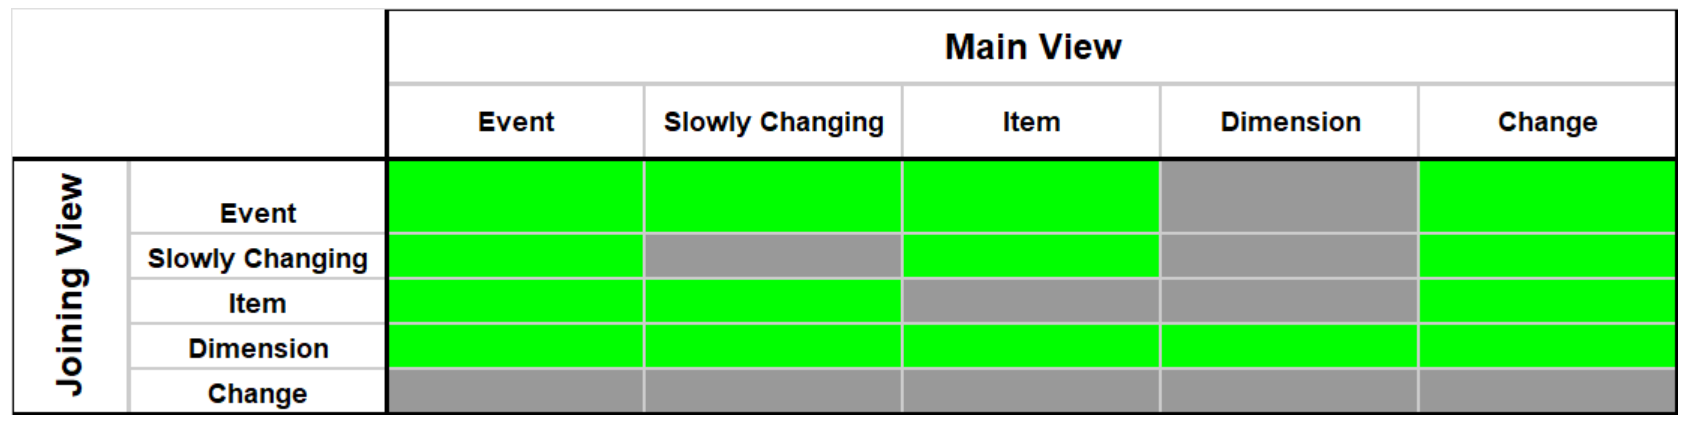

### Concept: Joins can be avoided

With featurebyte, you don't always need to join views to get the features you want.

1) <b>Entity relationships:</b> If a feature is calculated from a single table, and the entity level at which is calculated is the same as, or a parent of the entity level of your feature list, then featurebyte will use entity relationships to automatically apply that feature at the level of your feature list. For example, when state code is an entity, if you declare population of a US state as a feature, and your feature list operates at the customer entity level, featurebyte will know to use the state code of the customer to match the state population to the customer.
2) <b>Features built from features:</b> If a feature is calculated from attributes of more than one table, a user can first declare component features from each table, then declare a new feature that is a transformation of the combination of those component features. For example, you could declare a bank customer's income as a feature from the customer table, the average income per capita by US state as a feature from another table, then build a new feature that is the ratio of the bank customer's income to the state average.

## Next Steps

Now that you've completed the deep dive data modeling tutorial, you can put your knowledge into practice or learn more:<br>
1. Put your knowledge into practice by data modeling the cerdit card and healthcare datasets
2. Learn more about materializing features via the "Deep Dive Materializing Features" tutorial
3. Learn about managing features via the "Quick Start Feature Management" tutorial